In [63]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
import keras
from keras import layers

In [64]:
# upload data
df = pd.read_csv("balanced_dataset.csv")
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,20.34,0,0,1,0,0,0,0,80,0,0,1,3,7,0,0,0
1,0,24.21,0,0,0,0,0,0,0,77,0,0,0,2,6,0,0,1
2,0,31.64,1,0,0,5,0,1,0,80,0,2,0,2,9,1,0,0
3,0,28.37,1,0,0,0,0,1,1,77,0,2,1,3,8,0,0,0
4,0,28.15,0,0,0,7,0,1,0,80,0,0,0,2,7,0,0,0


In [65]:
# printing out the column names for easier copying for X/y
df.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [66]:
#  X/y -variables

# if you  have more than one independent variables, list them all here
# leave out the target variable! (dependent variable)
# in this case, everything else except the amount_paid
X = df[['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer']]

# have only the target variable here (dependent variable)
# in this case, amount_paid => how big is the electricity bill
y = df['HeartDisease']

In [67]:
#  Train/test/validation -split

# unfortunately the scikit-learn's train_test_split doesn't support validation
# set split in itself.
# if you want to split the test set into two for a validation set too, try this trick:

# first, train/test split => 70% for training, 30% for other purposes (temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)

# now, split the 30% for other purposes by 50% (resulting in 2 x 15%)
# so finally, we have:
# 70% for training
# 15% for testing
# 15% for validation
# => 70 + 15 +15 = 100%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)

In [68]:
# just seeing how much data we have in each
print(f"Train data amount: {len(X_train)}")
print(f"Test data amount: {len(X_test)}")
print(f"Validation data amount: {len(X_val)}")

Train data amount: 139688
Test data amount: 29934
Validation data amount: 29933


In [69]:
# save the categories into a list
categories = list(np.unique(df['HeartDisease']))
print(categories)

[0, 1]


In [70]:
 # let's try with a simple neural network
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_4           │ (None, 17)             │            68 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 510 (1.99 KB)

 Trainable params: 476 (1.86 KB)

 Non-trainable params: 34 (136.00 B)

In [71]:
#  Train the neural network with our data

 # using validation again for better metrics and optimization
model.fit(x=X_train, y=y_train, epochs=400, validation_data=(X_val, y_val))

Epoch 1/400


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 2)

<Axes: >

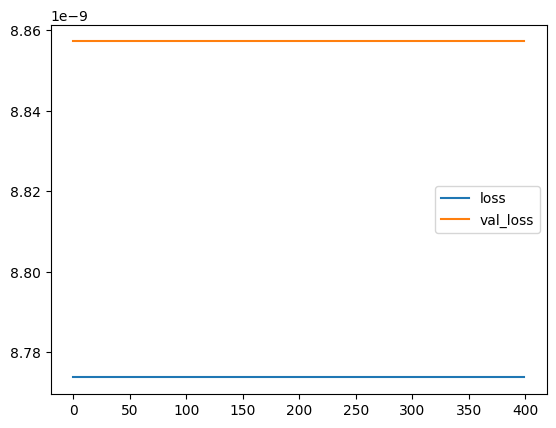

In [ ]:
#  Training metrics
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

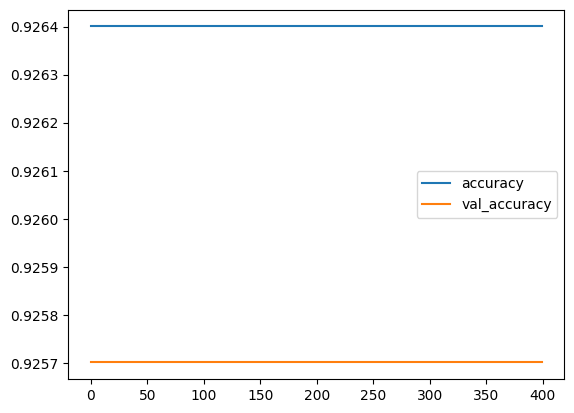

In [ ]:
loss_df[['accuracy', 'val_accuracy']].plot()

# KeyError: "None of [Index(['accuracy', 'val_accuracy'], dtype='object')] are in the [columns]"

In [ ]:
 # compare test error values to training error values
# the model is often good when these error values are similar
# even if you training metrics above didn't overlap
# you might still get very close values in evaluation => more important

# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

# The train loss (0.0589) and test loss (0.0595) are very close
# this is a good sign :)

Test data evaluation:
[8.844921239870018e-09, 0.9258034229278564]

Train data evaluation:
[8.77377281938152e-09, 0.9264002442359924]


In [ ]:
 # get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

936/936 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step


ValueError: `axis` must be fewer than the number of dimensions (1)

In [ ]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

NameError: name 'confusion_matrix' is not defined

In [ ]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions, target_names=categories))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

In [ ]:
# In multi category classification , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# get ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")